# Energy Consumption Forecast

The **main goal** is to build an energy consumption forecaster of a blower machine. <br>
In this scenario, I'm going to build a model that performs **daily forecasts**.
You can download the data [here](https://www.kaggle.com/datasets/vitthalmadane/energy-consumption-time-series-dataset)

I used the **MLFlow** to track my experiments in building a time-series **forecaster**.

In [1]:
import glob
import mlflow
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

**Set-up MLflow tracking URI, autolog and experiment's name**

In [2]:
#. Set experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.autolog()
mlflow.set_experiment("Energy Consumption Forecast")

<Experiment: artifact_location='mlflow-artifacts:/125988578747320284', creation_time=1708284458982, experiment_id='125988578747320284', last_update_time=1708284458982, lifecycle_stage='active', name='Energy Consumption Forecast', tags={}>

## Load Data

Load multiple csv files into one dataset.

- Information:
  - Two months of data - from January to February 2022.
  - A total of 3606 data-points.
  - The data (Kw/H) is read every 20 minutes, on average (i.e. calculate the delta of the logged time to get information).

In [3]:
data_folder = "data"

data = pd.concat(map(pd.read_csv, glob.glob(f"{data_folder}/*.csv")))
data.head(5)

,Unnamed: 0,TxnDate,TxnTime,Consumption
0,0,01 Feb 2022,14:41:48,1.016
1,1,01 Feb 2022,17:28:44,0.928
2,2,01 Feb 2022,19:51:07,0.988
3,3,01 Feb 2022,07:26:39,1.126
4,4,01 Feb 2022,05:20:47,0.886


## Preprocess data

For the preprocessing phase, I performed the following steps:
- Merging date and time columns into a Data-Time columns (i.e. convert using pandas to_datetime)-
- Drop unecessary column(s).
- Set new date-time column as index.
- Changing the frequency time-series data to `hour` (i.e. use resample). 

`Note: It said that the data is already stationary. Therefore, we do not need to make it stationary.`

,Consumption
TxnDateTime,
2022-01-01,65.462
2022-01-02,268.450
2022-01-03,236.566
2022-01-04,222.020
2022-01-05,380.630


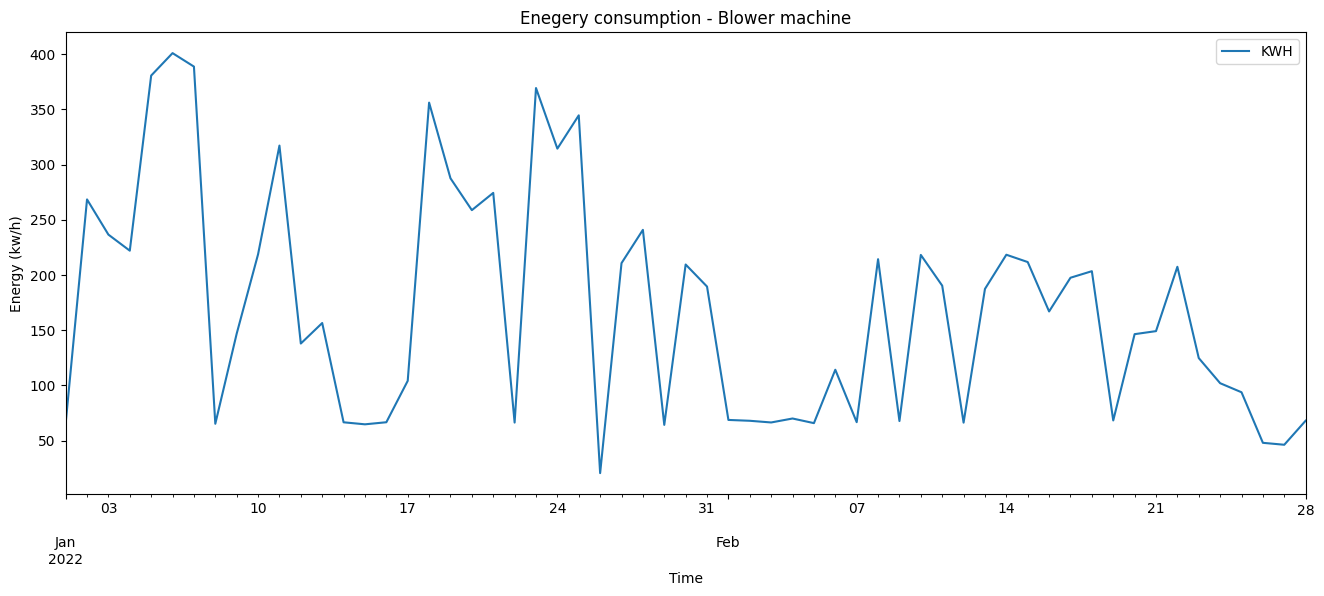

In [4]:
#. Merge date and time columns
data["TxnDateTime"] = pd.to_datetime(data["TxnDate"] + " "+ data["TxnTime"])
data.sort_values(by="TxnDateTime", inplace=True)

#. Drop uncessary column(s)
data.drop(["Unnamed: 0", "TxnDate", "TxnTime"], axis=1, inplace=True)

#. Set index
data.set_index("TxnDateTime", inplace=True)

#. Resample timeseries
data = data.resample("D").sum()
#data["Consumption"] = data["Consumption"].apply("log")

#. Show results
display(data.head(5))
ax = data["Consumption"].plot(figsize=(16,6), label="KWH", legend=True)
ax.set(title="Enegery consumption - Blower machine", 
       xlabel="Time", 
       ylabel="Energy (kw/h)");

## Consumption Forecast

In this section, I'm going to build a **forecaster** to predict the cosumption of a blower machine.

In [5]:
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer

2024/04/21 17:46:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/04/21 17:46:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/04/21 17:46:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/04/21 17:46:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Scalecast + XGBoost

Forecast `Energy Consumption` with a **XGBoost** model. <br>
I still check if the timeseries data is stationary by applying the `Augmented Dickey-Fuller` test.

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -5.21
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2
0,0.587,0.009,0.413,1.0,34.979,0.586,28.924,0.838


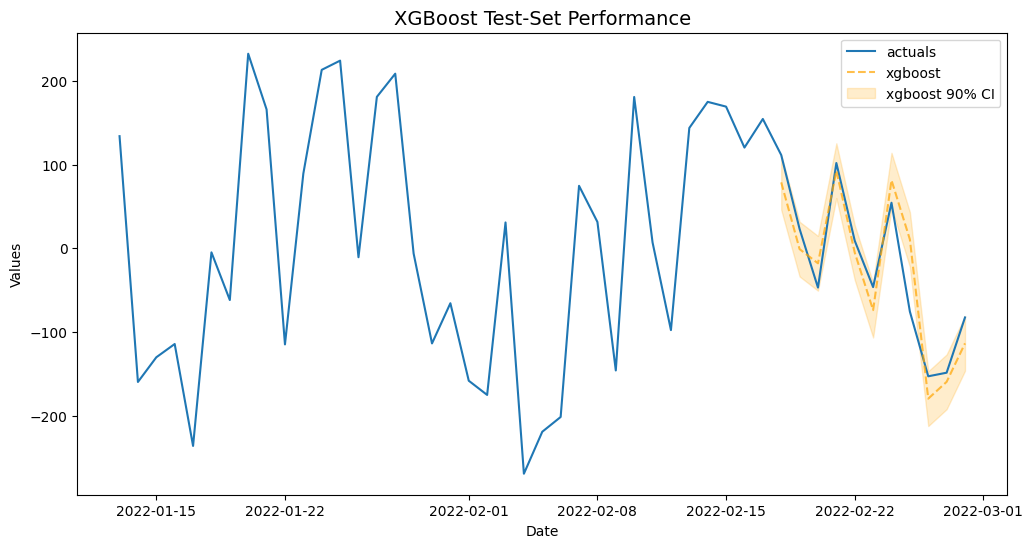

In [6]:
with mlflow.start_run():
    fcster = Forecaster(
        y=data["Consumption"], 
        current_dates=data.index, 
        future_dates=21, 
        metrics = ['rmse','mape','mae','r2'],
    )

    critical_pval = 0.05
    print('-'*100)
    print('Augmented Dickey-Fuller results:')
    stat, pval, _, _, _, _ = fcster.adf_test(full_res=True)
    print('the test-stat value is: {:.2f}'.format(stat))
    print('the p-value is {:.4f}'.format(pval))
    print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
    print('-'*100)

    fcster.set_test_length(.2)
    fcster.eval_cis(mode=True, cilevel=.90)

    transformer = SeriesTransformer(fcster)
    fcster = transformer.DiffTransform(12)
    fcster = transformer.DetrendTransform()

    #. Forecasting
    fcster.set_estimator("xgboost")
    fcster.add_ar_terms(12)
    fcster.manual_forecast(
        n_estimators=1000, 
        gamma=2, 
        eta=0.6, 
        max_depth=6)

    #. Display metrics
    metrics_features = ["InSampleRMSE", "InSampleMAPE", "InSampleMAE", "InSampleR2", 
                        "TestSetRMSE", "TestSetMAPE", "TestSetMAE", "TestSetR2"]
    model_summaries = fcster.export(dfs='model_summaries')
    model_summaries = model_summaries[metrics_features].round(3)
    model_summaries_log = model_summaries.to_dict(orient='index')[0]
    mlflow.log_metrics(metrics=model_summaries_log)
    display( model_summaries )

    #. Plot test set
    fcster.plot_test_set(ci=True)
    plt.title('XGBoost Test-Set Performance',size=14)
    plt.show()

#### Revert transformations

From a `XGBoost` model, the data transformations must be reverted before checking the forecastings.

In [7]:
#. Revert transformations
fcster = transformer.DetrendRevert()
fcster = transformer.DiffRevert(12)

#. Drop all Xvars
fcster.drop_all_Xvars()

#### Energy forecasts

Forecasts from a `XGBoost` model.

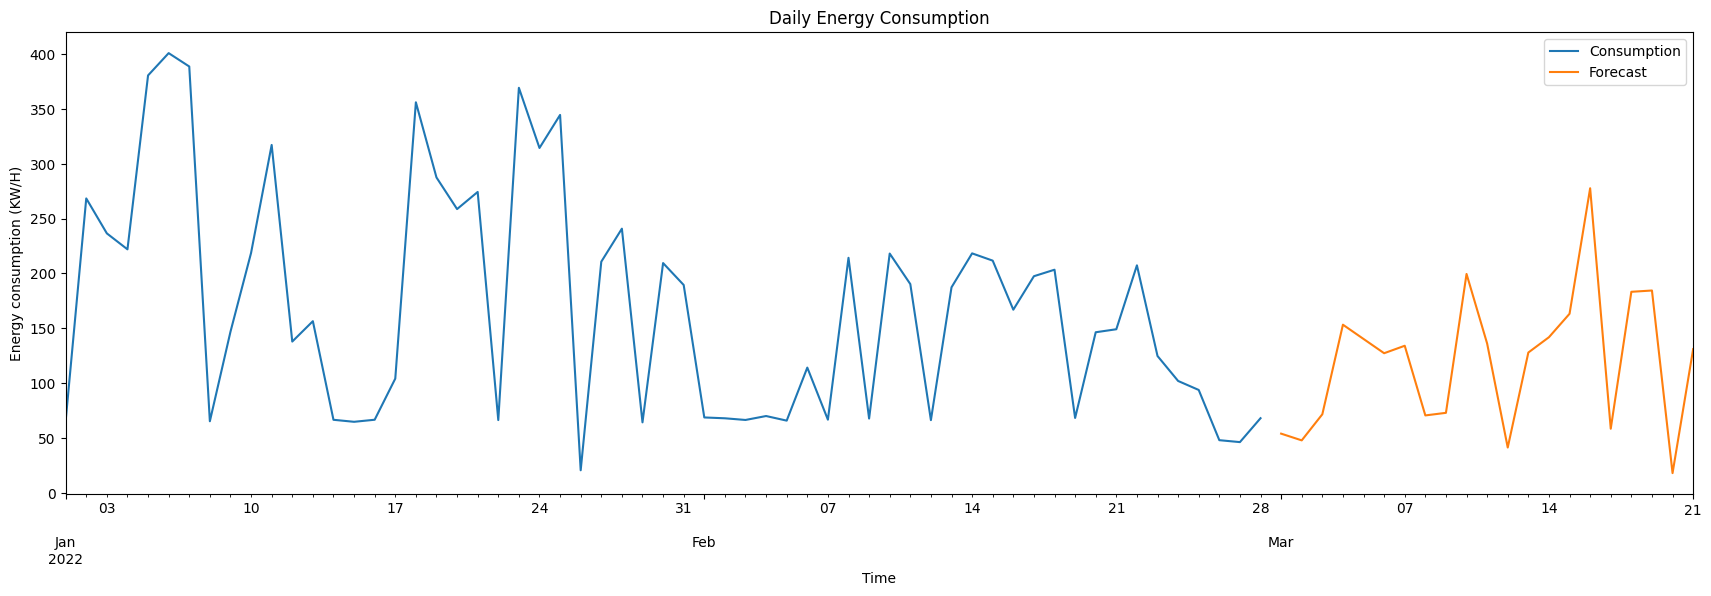

In [8]:
#. Get forecasts
fcst_feature = "Forecast"
f_forecast = fcster.history.get("xgboost").get("Forecast")
f_forecast_df = pd.DataFrame(f_forecast, 
                            columns=[fcst_feature], 
                            index=fcster.future_dates)

#. Fix negative forecasts
f_forecast_df.loc[f_forecast_df[fcst_feature] < 0, fcst_feature] = np.nan
f_forecast_df[fcst_feature] = f_forecast_df[fcst_feature].interpolate()

#. Plot energy consumption forecasts
ax = data.plot(figsize=(21,6))
f_forecast_df.plot(label="Forecast", ax=ax)

ax.set(title="Daily Energy Consumption", 
       xlabel="Time", 
       ylabel="Energy consumption (KW/H)");

#### Total Energy Consumption

What's the `Total Energy Operating` over time?

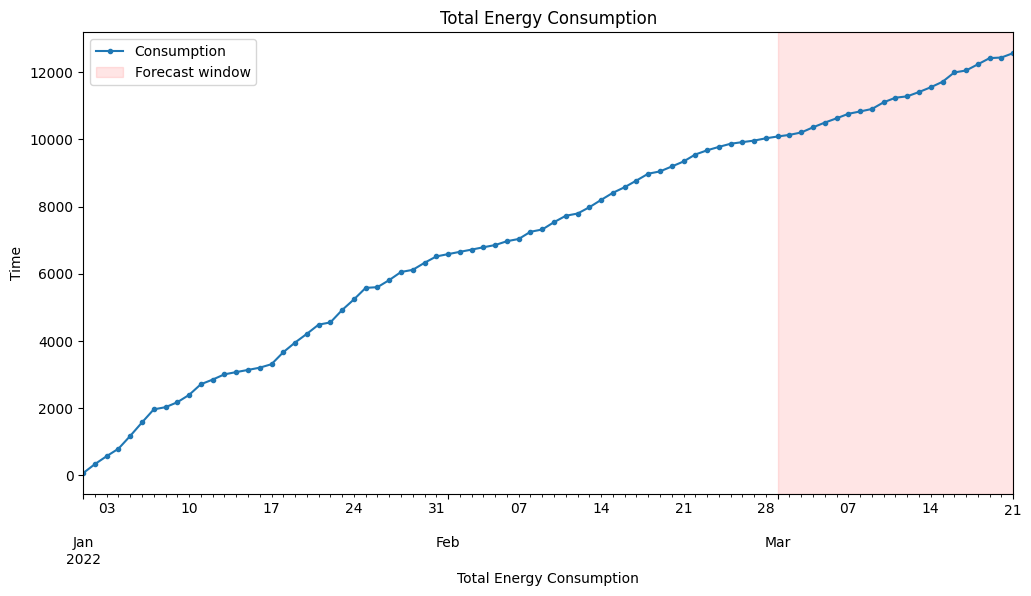

In [9]:
#. Appending dataset
consumption_df = pd.concat([
    data, 
    f_forecast_df.rename(columns={"Forecast": "Consumption"})])

#. Line plot: Total Energy Consumption
ax = consumption_df.cumsum().plot(marker='.', figsize=(12,6))
ax.set(title="Total Energy Consumption", 
       xlabel="Total Energy Consumption", 
       ylabel="Time")

#. Forecast windows
plt.axvspan(xmin=fcster.future_dates.loc[0],
            xmax=fcster.future_dates.iloc[-1], 
            ymin=0, ymax=1, color='red', alpha=0.1)
plt.legend(["Consumption", "Forecast window"]);

___

## LSTM

Try ***Long Short-Term Memory*** to predict/forecast the energy consumption.

## Use LSTM to predict/forecast machine energy consumption

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

### Functions

In [67]:
def create_sequences_data(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

### Preprocessing

In [68]:
# Copy data
energy_consumption = data['Consumption'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
energy_consumption_scaled = scaler.fit_transform(energy_consumption)

# Split the data into training and testing sets
train_size = int(len(energy_consumption_scaled) * 0.7)
test_size = len(energy_consumption_scaled) - train_size
train_data, test_data = energy_consumption_scaled[0:train_size,:], energy_consumption_scaled[train_size:len(energy_consumption_scaled),:]

seq_length = 5  # Number of previous time steps to use as input
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Build LSTM model

2024/04/21 21:42:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '60354c5242174f88bbaacbc8be920254', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


1/1 [==============================] - 0s 12ms/step
Train RMSE: 121.26036519322318
Test RMSE: 59.04001699558708


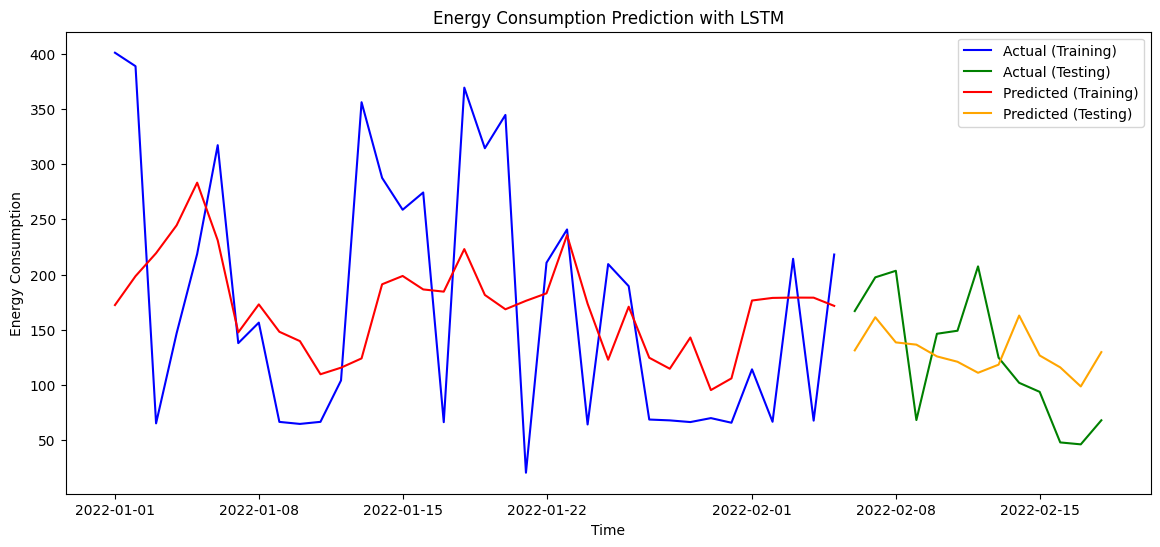

In [69]:
# Sequential
model = Sequential()
model.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=70))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=400, batch_size=20, shuffle=False, verbose=0)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scaling for predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform([y_train])
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(np.mean(np.square(train_predictions - y_train)))
test_rmse = np.sqrt(np.mean(np.square(test_predictions - y_test)))
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(data.index[:len(train_predictions)], y_train.flatten(), label="Actual (Training)", color='blue')
plt.plot(data.index[len(train_predictions):(len(train_predictions) + len(test_predictions))], y_test.flatten(), label="Actual (Testing)", color='green')
plt.plot(data.index[:len(train_predictions)], train_predictions, label="Predicted (Training)", color='red')
plt.plot(data.index[len(train_predictions):(len(train_predictions) + len(test_predictions))], test_predictions, label="Predicted (Testing)", color='orange')
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.title("Energy Consumption Prediction with LSTM")
plt.legend()
plt.show()


___

## MLflow Experiments

Here's a screenshot of the Energy Consumption experiments:
<p>
<img src='https://github.com/soutogustavo/Data-Science-Projects/assets/9319823/1b565b91-b83c-4c59-918c-e0349d363519' width="1200px" height="532"></img>

___